# Семинар 3. Обучение сверточных нейросетей в Pytorch

На этом семинаре мы будем обучать LeNet-5 на данных MNIST (и не только :). Мы наконец перестанем реализовывать все самостоятельно и будем пользоваться готовым функционалом pytorch.

Для начала ознакомимся с парой примеров обучения модели:
* [Пример 1](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py)
* [Пример 2](https://github.com/jcjohnson/pytorch-examples/blob/master/nn/two_layer_net_nn.py)

### Загрузка данных в pytorch

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.utils.data

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

В этот раз мы будем работать MNIST: он отличается от digits разрещением изображений (28x28 вместо 8x8) и числом объектов (60000 в обучении вместо 1797). 

В pytorch есть своя обертка, позволяющая скачивать MNIST, но нам будет удобнее скачать его самостоятельно.

In [3]:
from util import load_mnist

In [4]:
X_train, y_train, X_test, y_test = load_mnist()

Помимо обучающей и контрольной, нам понадобится валидационная выборка, чтобы настраивать гиперпараметры. Ее можно отделить от обучающей выборки (например, 25% = 15000 объектов). Однако модель несколько долго обучается даже на 75% обучающей выборки (несколько минут), что не очень хорошо для семинара. Поэтому для валидационных целей предлагается обучающую выборку также сжать до 15000 объектов. Финальную модель будем обучать по всей выборке.

In [5]:
# shuffle data
np.random.seed(0)
idxs = np.random.permutation(np.arange(X_train.shape[0]))
X_train, y_train = X_train[idxs], y_train[idxs]
                    
X_train.shape

(60000, 1, 28, 28)

В pytorch есть удобный класс для генерации батчей - DataLoader. Ему на вход надо подать объект класса TensorDataset, слудащий оберткой над матрицами данных.

In [6]:
def get_loader(X, y, batch_size=64):
    train = torch.utils.data.TensorDataset(torch.from_numpy(X).float(), 
                                       torch.from_numpy(y))
    train_loader = torch.utils.data.DataLoader(train, 
                                               batch_size=batch_size)
    return train_loader

# for final model:
train_loader_full = get_loader(X_train, y_train) 
test_loader = get_loader(X_test, y_test)
# for validation purposes:
train_loader = get_loader(X_train[:15000], y_train[:15000])
val_loader = get_loader(X_train[15000:30000], y_train[15000:30000])

/home/serega/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# check number of objects
val_loader.dataset.tensors[0].shape

torch.Size([15000, 1, 28, 28])

### Задание модели LeNet-5

Сверточный слой (из презентации Антона Осокина):
![Слайд про свертки из презентации Антона Осокина](https://github.com/nadiinchi/dl_labs/raw/master/convolution.png)

Нам надо реализовать LeNet-5:

![Архитектура LeNet-5](https://cdnpythonmachinelearning.azureedge.net/wp-content/uploads/2017/09/lenet-5-825x285.png?x64257)

Соберите нейросеть в соответствии с изображениями и примерами кода, которые были даны выше. В качестве нелинейности используйте ReLU (после всех сверточных и полносвязных слоев). Кроме того, нейросеть должна поддерживать увеличение числа сверток во всех сверточных слоях в k раз. 

Обратите внимание, что на схеме вход имеет размерность 32x32, а у нас - 28x28 (см. ячейку выше). Применять софтмакс в конце прохода вперед не нужно.

In [103]:
class CNN(nn.Module):
    def __init__(self, k=1):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(1, 24, 3),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2, 2),
                                  nn.Conv2d(24, 64, 4),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2, 2)
                                  )
        self.classifer = nn.Sequential(nn.Linear(1600, 10)
                                       #nn.Linear(84, 10)
                                       )
       
    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.shape[0], -1)
        out = self.classifer(out)
        return out
        

Посчитаем параметры нейросети:

In [104]:
cnn = CNN()

In [106]:
def count_parameters(model):
    return sum(param.data.numpy().size for param \
               in model.parameters() if param.requires_grad)

count_parameters(cnn)

40890

### Обучение нейросети

Определим функцию потерь:

In [107]:
criterion = nn.CrossEntropyLoss() # loss includes softmax

Также определим устройство, на котором будем хранить данные и модель (cpu или gpu), и перенем на него модель:

In [108]:
#device = torch.device('cpu')
device = torch.device('cuda') # Uncomment this to run on GPU
cnn = cnn.to(device)

Во время обучения модели удобно контролировать качество и на обучении, и на контроле (валидации) - возникает дублирующий код. Поэтому мы вынесем в отдельную функцию оценку модели, и в отдельную функцию - эпоху обучения. Это позволит также честно оценивать значение критерия качества на всей обучающей выборке по окончании эпохи (а не усреднять значения на минибатчах).

В прототипах указано про train и eval mode: в нашем случае они не нужны (были бы нужны, если бы мы использовали дропаут или батч-нормализацию, к примеру). Но чтобы вы могли использовать этот код в будущем, лучше указывать переключение режима.

In [109]:
def train_epoch(model, optimizer, train_loader, criterion, device):
    model.train()
    for idx, (inp, targets) in enumerate(train_loader):
        inp = inp.to(device)
        targets = torch.tensor(targets, dtype=torch.long, device=device)
        optimizer.zero_grad()
        out = model(inp)
        loss = criterion(out, targets)
        loss.backward()
        optimizer.step()
    
def evaluate_loss_acc(loader, model, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for idx, (inp, targets) in enumerate(loader):
            inp = inp.to(device)
            targets = torch.tensor(targets, dtype=torch.long, device=device)
            out = model(inp)
            loss = criterion(out, targets)
            test_loss += loss.item()
            _, pred = out.max(1)
            total += targets.shape[0]
            correct += pred.eq(targets).sum().item()
    return (test_loss / (idx + 1), correct / total * 100.0)
    
def train(model, opt, train_loader, test_loader, criterion, n_epochs, \
          device, verbose=True):
    
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        train_epoch(model, opt, train_loader, criterion, device)
        train_loss, train_acc = evaluate_loss_acc(train_loader, 
                                                  model, criterion, 
                                                  device)
        val_loss, val_acc = evaluate_loss_acc(test_loader, model, 
                                              criterion, device)

        train_log.append(train_loss)
        train_acc_log.append(train_acc)

        val_log.append(val_loss)
        val_acc_log.append(val_acc)
        
        if verbose:
             print (('Epoch [%d/%d], Loss (train/test): %.4f/%.4f,'+\
               ' Acc (train/test): %.4f/%.4f' )
                   %(epoch+1, n_epochs, \
                     train_loss, val_loss, train_acc, val_acc))
            
    return train_log, train_acc_log, val_log, val_acc_log

Обучите нейронную сеть, используя определенные функции. Установите Adam в качестве оптимизатора, learning_rate=0.001, число эпох - 20. В качестве test_loader используйте валидационную выборку.

In [110]:
optim = torch.optim.Adam(cnn.parameters(), lr = 0.001)
train_log, train_acc_log, val_log, val_acc_log = train(cnn, optim, \
                                                 train_loader, test_loader, criterion, 20, device, verbose=True)

/home/serega/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/home/serega/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/20], Loss (train/test): 0.1321/0.1301, Acc (train/test): 96.2467/96.3200
Epoch [2/20], Loss (train/test): 0.0728/0.0807, Acc (train/test): 97.8667/97.4300
Epoch [3/20], Loss (train/test): 0.0540/0.0680, Acc (train/test): 98.2800/97.7800
Epoch [4/20], Loss (train/test): 0.0391/0.0592, Acc (train/test): 98.7467/98.1100
Epoch [5/20], Loss (train/test): 0.0299/0.0548, Acc (train/test): 99.1067/98.3800
Epoch [6/20], Loss (train/test): 0.0266/0.0568, Acc (train/test): 99.2133/98.3300
Epoch [7/20], Loss (train/test): 0.0238/0.0592, Acc (train/test): 99.2800/98.2000
Epoch [8/20], Loss (train/test): 0.0193/0.0588, Acc (train/test): 99.3600/98.2900
Epoch [9/20], Loss (train/test): 0.0179/0.0601, Acc (train/test): 99.3667/98.2800
Epoch [10/20], Loss (train/test): 0.0229/0.0686, Acc (train/test): 99.2067/98.1500
Epoch [11/20], Loss (train/test): 0.0193/0.0708, Acc (train/test): 99.2733/98.0900
Epoch [12/20], Loss (train/test): 0.0149/0.0653, Acc (train/test): 99.4800/98.2400
Epoch [13/20]

Визуализируем результат прохождения изображения через слои. Код ниже отрисовывает сетку изображений: первый столбец - изображения цифр, следующие 6 столбцов - результаты применения фильтров к ним. Чтобы им воспользоваться, сохраните в x переменную, храняющую батч из 10 изображений, в y - результат применения первого слоя к x.

In [51]:
x = X_train[:10]
conv = nn.Conv2d(1, 6, 3)
x = torch.from_numpy(x)
y = conv(x)

In [53]:
def plot(x, y):
    plt.figure(figsize=(15, 15))
    for im in range(10):
        plt.subplot(11, 7, im*7+1)
        plt.imshow(x.data[im, 0])
        plt.axis("off")
        for i in range(6):
            plt.subplot(11, 7, im*7+i+2)
            plt.imshow(y.data[im, i].numpy())
            plt.axis("off")

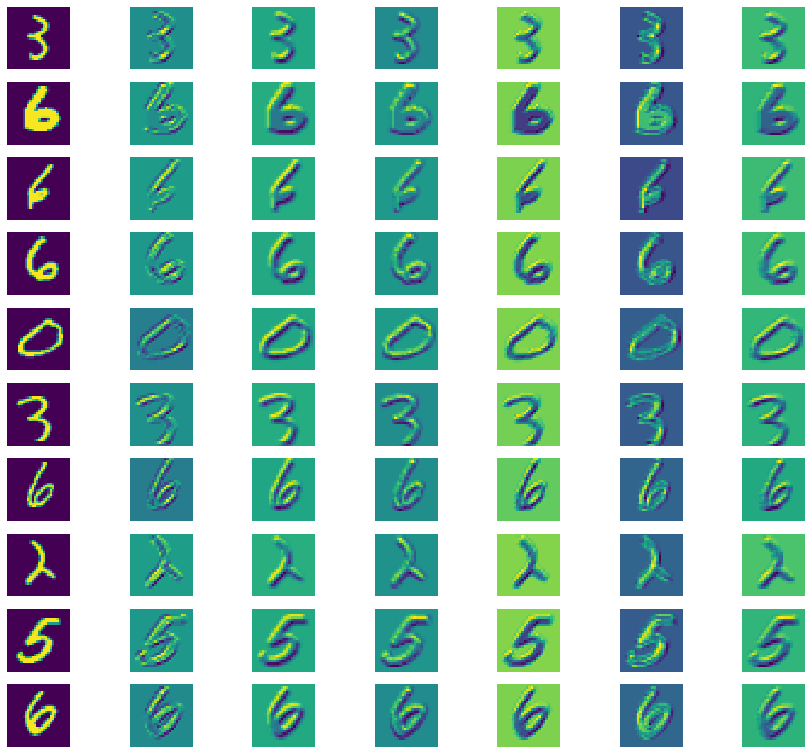

In [54]:
plot(x, y)

Затем визуализируйте результат применения второго сверточного слоя (после всех предыдущих слоев):

In [64]:
x = X_train[:10]
conv = nn.Conv2d(1, 6, 3)
conv2 = nn.Conv2d(6, 6, 3)
x = torch.from_numpy(x)
y = conv2(F.max_pool2d(F.relu(conv(x)), 2))

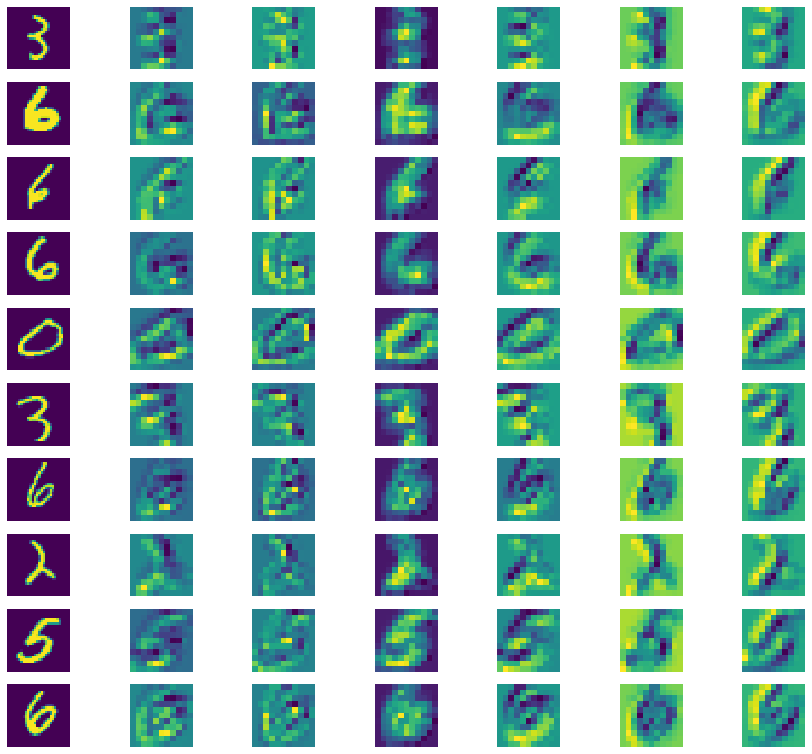

In [65]:
plot(x, y)


### Подбор длины шага и размера батча

Постройте графики точности (accuracy) на обучающей и валидационной выборке в зависимости от номера эпохи при разных параметрах обучения: learning rate$ \in \{0.0001, 0.001, 0.01\}$, batch size $\in \{64, 256\}$. 

Лучше всего отображать кривые для обучения на левом графике, кривые для валидации - на правом с общей осью y (plt.ylim).

Как влияют длина шага и размер батча на итоговое качество?

In [ ]:
### your code here (честно - поленился это сделать)

### Изменение архитектуры

Попробуйте модифицировать архитектуру нейросети: увеличить число фильтров и уменьшить число полносвязных слоев. 

Впишите цифры в скобки:
* LeNet-5 классич. (6 и 16 сверток):  качество на обучении: (99.7133)  качество на валидации: (97.9500)
* Увеличение в 4 раза (24 и 64 сверток):  качество на обучении: (99.9800)  качество на валидации: (98.7000)
* Удаление полносвзяного слоя: предыдущая нейросеть с 1 полносвязным слоем: качество на обучении: (99.9000)  качество на валидации: (98.3300)
    
    

In [111]:
### your code here(я просто менял данные в предыдущем коде, надеюсь так было можно)

Выберите длину шага, размер батча и архитектуру по валидационной выборке, обучите нейросеть на полной обучающей выборке и выведите качество на контрольной выборке. Хуже ли оно, чем на валидационной выборке?

In [112]:
def get_loader(X, y, batch_size=256):
    train = torch.utils.data.TensorDataset(torch.from_numpy(X).float(), 
                                       torch.from_numpy(y))
    train_loader = torch.utils.data.DataLoader(train, 
                                               batch_size=batch_size)
    return train_loader

# for final model:
train_loader = get_loader(X_train, y_train) 
test_loader = get_loader(X_test, y_test)
# for validation purposes:
# train_loader = get_loader(X_train[:15000], y_train[:15000])
# val_loader = get_loader(X_train[15000:30000], y_train[15000:30000])

class CNN(nn.Module):
    def __init__(self, k=1):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(1, 24, 3),
                                  nn.BatchNorm2d(24),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2, 2),
                                  nn.Conv2d(24, 64, 4),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2, 2)
                                  )
        self.classifer = nn.Sequential(nn.Linear(1600, 84),
                                       nn.Linear(84, 10)
                                       )
       
    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.shape[0], -1)
        out = self.classifer(out)
        return out
        

In [116]:
def train_epoch(model, optimizer, train_loader, criterion, device):
    model.train()
    for idx, (inp, targets) in enumerate(train_loader):
        inp = inp.to(device)
        targets = torch.tensor(targets, dtype=torch.long, device=device)
        optimizer.zero_grad()
        out = model(inp)
        loss = criterion(out, targets)
        loss.backward()
        optimizer.step()
    
def evaluate_loss_acc(loader, model, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for idx, (inp, targets) in enumerate(loader):
            inp = inp.to(device)
            targets = torch.tensor(targets, dtype=torch.long, device=device)
            out = model(inp)
            loss = criterion(out, targets)
            test_loss += loss.item()
            _, pred = out.max(1)
            total += targets.shape[0]
            correct += pred.eq(targets).sum().item()
    return (test_loss / (idx + 1), correct / total * 100.0)
    
def train(model, opt, train_loader, test_loader, criterion, n_epochs, \
          device, verbose=True):
    
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        if epoch % 5 == 0 and epoch != 0:
            for g in optim.param_groups:
                g['lr'] = g['lr'] * 0.1
        train_epoch(model, opt, train_loader, criterion, device)
        train_loss, train_acc = evaluate_loss_acc(train_loader, 
                                                  model, criterion, 
                                                  device)
        val_loss, val_acc = evaluate_loss_acc(test_loader, model, 
                                              criterion, device)

        train_log.append(train_loss)
        train_acc_log.append(train_acc)

        val_log.append(val_loss)
        val_acc_log.append(val_acc)
        
        if verbose:
             print (('Epoch [%d/%d], Loss (train/test): %.4f/%.4f,'+\
               ' Acc (train/test): %.4f/%.4f' )
                   %(epoch+1, n_epochs, \
                     train_loss, val_loss, train_acc, val_acc))
    return train_log, train_acc_log, val_log, val_acc_log

In [117]:
cnn = CNN()
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda') # Uncomment this to run on GPU
cnn = cnn.to(device)
optim = torch.optim.Adam(cnn.parameters(), lr = 0.001)
train_log, train_acc_log, val_log, val_acc_log = train(cnn, optim, \
                                                 train_loader, test_loader, \
                                                       criterion, 20, device, verbose=True)

/home/serega/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/home/serega/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/20], Loss (train/test): 0.0523/0.0486, Acc (train/test): 98.5150/98.4500
Epoch [2/20], Loss (train/test): 0.0362/0.0380, Acc (train/test): 98.8917/98.7900
Epoch [3/20], Loss (train/test): 0.0419/0.0472, Acc (train/test): 98.6083/98.5000
Epoch [4/20], Loss (train/test): 0.0368/0.0455, Acc (train/test): 98.7517/98.5000
Epoch [5/20], Loss (train/test): 0.0222/0.0375, Acc (train/test): 99.3000/98.8100
Epoch [6/20], Loss (train/test): 0.0092/0.0248, Acc (train/test): 99.7667/99.0800
Epoch [7/20], Loss (train/test): 0.0080/0.0248, Acc (train/test): 99.8067/99.1300
Epoch [8/20], Loss (train/test): 0.0072/0.0250, Acc (train/test): 99.8467/99.1300
Epoch [9/20], Loss (train/test): 0.0066/0.0252, Acc (train/test): 99.8733/99.1200
Epoch [10/20], Loss (train/test): 0.0061/0.0254, Acc (train/test): 99.8900/99.1200
Epoch [11/20], Loss (train/test): 0.0057/0.0252, Acc (train/test): 99.9067/99.1300
Epoch [12/20], Loss (train/test): 0.0056/0.0253, Acc (train/test): 99.9067/99.1400
Epoch [13/20]